#### 首先查看字符类型的种类数

In [8]:
import pandas as pd
import numpy as np

df = pd.read_csv('Train.csv')
print("total: ", len(df))
for column in df.columns:

    
    if not df[column].dtype in ['int64', 'float64']:
        print(column, df[column].unique(), len(df[column].unique()))
    
    missing = df[column].isnull().sum()
    if missing > 0:
        print(column, f"缺失值数量: {missing}")

total:  7487
Gender 缺失值数量: 130
Graduate 缺失值数量: 77
Profession ['Artist' 'Homemaker' 'Lawyer' 'Entertainment' nan 'Doctor' 'Engineer'
 'Healthcare' 'Executive' 'Marketing'] 10
Profession 缺失值数量: 112
Years_of_Working  缺失值数量: 742
Spending_Score ['Low' 'High' 'Average'] 3
Family_Members 缺失值数量: 310
Category ['Cat_6' 'Cat_3' 'Cat_4' 'Cat_2' 'Cat_7' 'Cat_5' nan 'Cat_1'] 8
Category 缺失值数量: 72
Class(Target) ['C' 'A' 'B' 'D'] 4


####  缺失值（数值型，字符型）填充， 类型编码

In [167]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

# 编码训练集
def convert_train_df(df):
    df = df.copy()
    
    # 删除ID列
    if 'ID' in df.columns:
        df = df.drop('ID', axis=1)
    # 处理缺失值
    # 对于数值型变量，将nan视为一个特殊类别
    numeric_cols = ['Gender', 'Graduate', 'Years_of_Working', 'Family_Members']
    for col in numeric_cols:
        # 创建一个新的二进制列来标记是否为nan
        df[f'{col}_is_nan'] = df[col].isna().astype(int)
        # 用-1填充nan（作为一个特殊值）
        df[col].fillna(-1, inplace=True)
    
    # 对于分类变量，将nan视为一个新的类别
    categorical_cols = ['Profession', 'Category']
    for col in categorical_cols:
        df[col].fillna('Unknown', inplace=True)
    
    # 编码处理
    # Spending_Score使用标签编码（因为是有序的）
    le_dict = {}
    for col in ['Spending_Score', 'Class(Target)']:
        le_dict[col] = LabelEncoder()
        df[col] = le_dict[col].fit_transform(df[col])
    
    # Profession和Category使用独热编码
    ct = ColumnTransformer([
        ('encoder', OneHotEncoder(sparse=False, drop='first', handle_unknown='ignore'), 
         ['Profession', 'Category'])
    ], remainder='passthrough')
    
    original_columns = df.columns.tolist()
    
    encoded_array = ct.fit_transform(df)
    
    profession_categories = ct.named_transformers_['encoder'].categories_[0][1:]
    category_categories = ct.named_transformers_['encoder'].categories_[1][1:]
    new_columns = [f'Profession_{cat}' for cat in profession_categories] + \
                  [f'Category_{cat}' for cat in category_categories] + \
                  [col for col in original_columns if col not in ['Profession', 'Category']]
    
    df_encoded = pd.DataFrame(encoded_array, columns=new_columns)
    print(df_encoded.info())
    return df_encoded, le_dict, ct

# 用同样的编码编码验证集测试集
def convert_df(df, le_dict, ct):
    
    df = df.copy()
    
    if 'ID' in df.columns:
        df = df.drop('ID', axis=1)
        
    numeric_cols = ['Gender', 'Graduate', 'Years_of_Working', 'Family_Members']
    for col in numeric_cols:
        df[f'{col}_is_nan'] = df[col].isna().astype(int)
        df[col].fillna(-1, inplace=True)
    
    categorical_cols = ['Profession', 'Category']
    for col in categorical_cols:
        df[col].fillna('Unknown', inplace=True)
    
    for col in ['Spending_Score', 'Class(Target)']:
        if col in df.columns:  
            df[col] = df[col].map(lambda x: x if x in le_dict[col].classes_ else le_dict[col].classes_[0])
            df[col] = le_dict[col].transform(df[col])
    
    original_columns = df.columns.tolist()
    
    encoded_array = ct.transform(df)
    
    profession_categories = ct.named_transformers_['encoder'].categories_[0][1:]
    category_categories = ct.named_transformers_['encoder'].categories_[1][1:]
    new_columns = [f'Profession_{cat}' for cat in profession_categories] + \
                  [f'Category_{cat}' for cat in category_categories] + \
                  [col for col in original_columns if col not in ['Profession', 'Category']]

    df_encoded = pd.DataFrame(encoded_array, columns=new_columns)
    return df_encoded

train = pd.read_csv('Train.csv')
train_encoded, le_dict, ct = convert_train_df(train)
train_encoded.to_csv('processed_train.csv', index=False)

val = pd.read_csv('Validate.csv')
val_encoded = convert_df(val, le_dict, ct)
val_encoded.to_csv('processed_val.csv', index=False)

test = pd.read_csv('Test.csv')
test_encoded = convert_df(test, le_dict, ct)
test_encoded.to_csv('processed_test.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7487 entries, 0 to 7486
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Profession_Doctor         7487 non-null   float64
 1   Profession_Engineer       7487 non-null   float64
 2   Profession_Entertainment  7487 non-null   float64
 3   Profession_Executive      7487 non-null   float64
 4   Profession_Healthcare     7487 non-null   float64
 5   Profession_Homemaker      7487 non-null   float64
 6   Profession_Lawyer         7487 non-null   float64
 7   Profession_Marketing      7487 non-null   float64
 8   Profession_Unknown        7487 non-null   float64
 9   Category_Cat_2            7487 non-null   float64
 10  Category_Cat_3            7487 non-null   float64
 11  Category_Cat_4            7487 non-null   float64
 12  Category_Cat_5            7487 non-null   float64
 13  Category_Cat_6            7487 non-null   float64
 14  Category

#### 此处是class 2训练效果一直不太好，尝试看看哪些特征可能和总体特征不一样

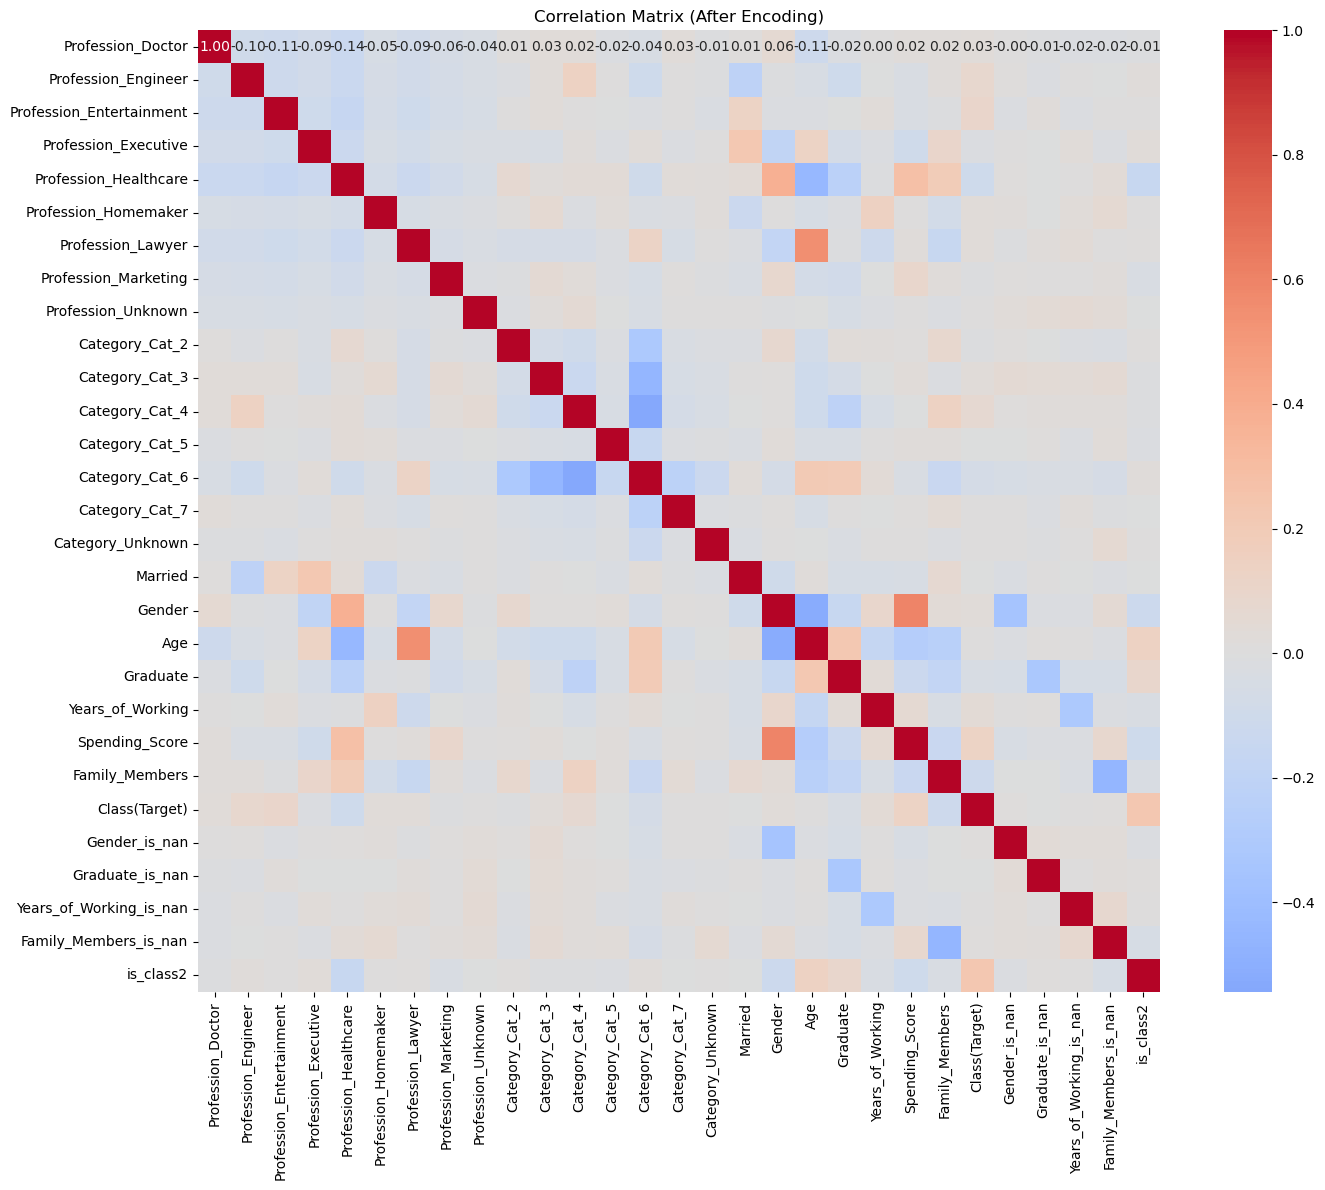


与Class(Target)的相关性（按绝对值排序）:
is_class2                   0.228829
Spending_Score              0.128139
Family_Members             -0.111283
Profession_Entertainment    0.100780
Profession_Healthcare      -0.098986
Profession_Engineer         0.085735
Category_Cat_4              0.070581
Category_Cat_6             -0.064703
Years_of_Working            0.041086
Graduate                   -0.038607
Profession_Lawyer           0.032772
Profession_Doctor           0.031444
Category_Cat_3              0.028901
Profession_Homemaker        0.027539
Gender                      0.027122
Profession_Executive       -0.019016
Family_Members_is_nan       0.013971
Gender_is_nan               0.011163
Category_Cat_2             -0.010354
Profession_Marketing       -0.009934
Category_Unknown            0.009128
Years_of_Working_is_nan     0.008691
Profession_Unknown          0.008444
Category_Cat_5             -0.006659
Married                    -0.003798
Category_Cat_7              0.001737
Graduate_

In [153]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15, 12))
corr_matrix = train_encoded.corr()
sns.heatmap(corr_matrix, 
            annot=True,
            cmap='coolwarm',
            center=0,
            fmt='.2f',
            square=True)

plt.title('Correlation Matrix (After Encoding)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

target_corr = corr_matrix['Class(Target)'].drop('Class(Target)')
print("\n与Class(Target)的相关性（按绝对值排序）:")
print(target_corr.reindex(target_corr.abs().sort_values(ascending=False).index))


# 计算Class 2的相关性
# 创建二元标签：1表示Class 2，0表示其他类
train_encoded['is_class_2'] = (train_encoded['Class(Target)'] == 2).astype(int)

# 计算与is_class_2的相关性
class_2_corr_matrix = train_encoded.corr()
class_2_target_corr = class_2_corr_matrix['is_class_2'].drop(['is_class_2', 'Class(Target)'])
print("\n与Class(Target)==2的相关性（按绝对值排序）:")
print(class_2_target_corr.reindex(class_2_target_corr.abs().sort_values(ascending=False).index))

# 删除临时列
train_encoded = train_encoded.drop('is_class_2', axis=1)

#### 训练模型

###### 随机森林

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

X_train = train_encoded.drop('Class(Target)', axis=1)
y_train = train_encoded['Class(Target)']
X_valid = val_encoded.drop('Class(Target)', axis=1)
y_valid = val_encoded['Class(Target)']
X_test = test_encoded.drop('Class(Target)', axis=1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

rf_model = RandomForestClassifier(random_state=42)

# 训练模型
rf_model.fit(X_train_scaled, y_train)

y_pred_rf = rf_model.predict(X_valid_scaled)
print(classification_report(y_valid, y_pred_rf))
print(confusion_matrix(y_valid, y_pred_rf))

              precision    recall  f1-score   support

         0.0       0.39      0.40      0.40       241
         1.0       0.47      0.61      0.53       271
         2.0       0.34      0.27      0.30       269
         3.0       0.37      0.34      0.36       288

    accuracy                           0.40      1069
   macro avg       0.39      0.40      0.40      1069
weighted avg       0.39      0.40      0.40      1069

[[ 96  47  57  41]
 [ 23 164  32  52]
 [ 74  51  73  71]
 [ 51  84  55  98]]


###### XGboost + 网格搜索

In [99]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

X_train = train_encoded.drop('Class(Target)', axis=1)
y_train = train_encoded['Class(Target)']
X_valid = val_encoded.drop('Class(Target)', axis=1)
y_valid = val_encoded['Class(Target)']
X_test = test_encoded.drop('Class(Target)', axis=1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

xgb_params = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'min_child_weight': [1, 3],
    'gamma': [0, 0.1],
    'subsample': [0.8, 1.0]
}

# from sklearn.model_selection import StratifiedKFold
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

xgb = XGBClassifier(random_state=42, objective='multi:softmax', num_class=4)
# xgb_grid = GridSearchCV(xgb, xgb_params, cv=skf, scoring='accuracy', n_jobs=-1)
xgb_grid = GridSearchCV(xgb, xgb_params, cv=5, scoring='accuracy', n_jobs=-1)
xgb_grid.fit(X_train_scaled, y_train)

y_pred_xgb = xgb_grid.predict(X_valid_scaled)
print(classification_report(y_valid, y_pred_xgb))
print(confusion_matrix(y_valid, y_pred_xgb))

              precision    recall  f1-score   support

         0.0       0.46      0.51      0.49       241
         1.0       0.56      0.68      0.61       271
         2.0       0.49      0.23      0.32       269
         3.0       0.42      0.50      0.45       288

    accuracy                           0.48      1069
   macro avg       0.48      0.48      0.47      1069
weighted avg       0.48      0.48      0.47      1069

[[124  38  28  51]
 [ 19 183  12  57]
 [ 75  39  63  92]
 [ 52  67  26 143]]


###### KNN

In [28]:
from sklearn.neighbors import KNeighborsClassifier

X_train = train_encoded.drop('Class(Target)', axis=1)
y_train = train_encoded['Class(Target)']
X_valid = val_encoded.drop('Class(Target)', axis=1)
y_valid = val_encoded['Class(Target)']
X_test = test_encoded.drop('Class(Target)', axis=1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

knn_params = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, knn_params, cv=5, scoring='accuracy', n_jobs=-1)
knn_grid.fit(X_train_scaled, y_train)

y_pred_knn = knn_grid.predict(X_valid_scaled)
print(classification_report(y_valid, y_pred_knn))
print(confusion_matrix(y_valid, y_pred_knn))

              precision    recall  f1-score   support

         0.0       0.37      0.47      0.41       241
         1.0       0.51      0.60      0.55       271
         2.0       0.33      0.25      0.28       269
         3.0       0.39      0.31      0.35       288

    accuracy                           0.41      1069
   macro avg       0.40      0.41      0.40      1069
weighted avg       0.40      0.41      0.40      1069

[[114  40  51  36]
 [ 30 163  25  53]
 [107  42  68  52]
 [ 58  75  65  90]]


###### SVC+网格搜素

In [29]:
from sklearn.svm import SVC

X_train = train_encoded.drop('Class(Target)', axis=1)
y_train = train_encoded['Class(Target)']
X_valid = val_encoded.drop('Class(Target)', axis=1)
y_valid = val_encoded['Class(Target)']
X_test = test_encoded.drop('Class(Target)', axis=1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf'],
    'gamma': ['scale', 'auto']
}

svm = SVC(random_state=42)
svm_grid = GridSearchCV(svm, svm_params, cv=5, scoring='accuracy', n_jobs=-1)
svm_grid.fit(X_train_scaled, y_train)

y_pred_svm = svm_grid.predict(X_valid_scaled)
print(classification_report(y_valid, y_pred_svm))
print(confusion_matrix(y_valid, y_pred_svm))

              precision    recall  f1-score   support

         0.0       0.46      0.49      0.48       241
         1.0       0.56      0.65      0.60       271
         2.0       0.41      0.22      0.29       269
         3.0       0.40      0.50      0.44       288

    accuracy                           0.46      1069
   macro avg       0.46      0.46      0.45      1069
weighted avg       0.46      0.46      0.45      1069

[[118  34  36  53]
 [ 20 175   7  69]
 [ 74  42  59  94]
 [ 42  60  42 144]]


###### 尝试提高类别2样本权重以增加其recall

In [134]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

X_train = train_encoded.drop('Class(Target)', axis=1)
y_train = train_encoded['Class(Target)']
X_valid = val_encoded.drop('Class(Target)', axis=1)
y_valid = val_encoded['Class(Target)']
X_test = test_encoded.drop('Class(Target)', axis=1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

# 对类别2使用更大的样本权重
sample_weights = np.ones(len(y_train))
sample_weights[y_train == 2.0] = 1.3 # 给类别2更大的权重

# 在XGBoost中使用样本权重
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train_scaled, y_train, sample_weight=sample_weights)

y_pred_xgb = xgb_model.predict(X_valid_scaled)
print(classification_report(y_valid, y_pred_xgb))
print(confusion_matrix(y_valid, y_pred_xgb))

              precision    recall  f1-score   support

         0.0       0.48      0.45      0.46       241
         1.0       0.53      0.63      0.58       271
         2.0       0.39      0.37      0.38       269
         3.0       0.40      0.36      0.38       288

    accuracy                           0.45      1069
   macro avg       0.45      0.45      0.45      1069
weighted avg       0.45      0.45      0.45      1069

[[108  36  64  33]
 [ 20 172  26  53]
 [ 55  42  99  73]
 [ 44  75  64 105]]


###### xgb + 自动调整样本权重 (ai生成后微改的) + 网格搜素

In [151]:
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
from itertools import product
import pandas as pd

# 准备数据
X_train = train_encoded.drop('Class(Target)', axis=1)
y_train = train_encoded['Class(Target)']
X_valid = val_encoded.drop('Class(Target)', axis=1)
y_valid = val_encoded['Class(Target)']
X_test = test_encoded.drop('Class(Target)', axis=1)

# 标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

# 定义要尝试的权重范围
weight_ranges = {
    0: np.arange(0.5, 5.1, 0.5),  # 类别0的权重范围
    1: np.arange(0.5, 5.1, 0.5),  # 类别1的权重范围
    2: np.arange(0.5, 5.1, 0.5),  # 类别2的权重范围
    3: np.arange(0.5, 5.1, 0.5)   # 类别3的权重范围
}

# 初始化最佳结果记录
best_accuracy = 0
best_weights = None
best_model = None
results = []

# 定义基础模型参数
base_model_params = {
    'random_state': 42,
    'learning_rate': 0.01,
    'n_estimators': 200,
    'max_depth': 4
}

# 使用二分搜索来加速搜索过程
def binary_search_weights(class_id, current_best_weights, current_best_accuracy):
    left, right = 0.5, 5.0
    while right - left > 0.1:
        mid = (left + right) / 2
        
        # 使用当前权重组合
        test_weights = current_best_weights.copy()
        test_weights[class_id] = mid
        
        # 创建样本权重数组
        sample_weights = np.ones(len(y_train))
        for cls, weight in test_weights.items():
            sample_weights[y_train == cls] = weight
        
        # 训练模型
        model = XGBClassifier(**base_model_params)
        model.fit(X_train_scaled, y_train, sample_weight=sample_weights)
        
        # 评估
        y_pred = model.predict(X_valid_scaled)
        accuracy = accuracy_score(y_valid, y_pred)
        
        # 记录结果
        results.append({
            'weights': test_weights.copy(),
            'accuracy': accuracy,
            'confusion_matrix': confusion_matrix(y_valid, y_pred)
        })
        
        # 更新最佳结果
        if accuracy > current_best_accuracy:
            current_best_accuracy = accuracy
            current_best_weights = test_weights.copy()
        
        # 二分搜索
        if accuracy > current_best_accuracy:
            left = mid
        else:
            right = mid
            
    return current_best_weights, current_best_accuracy

# 初始化权重
current_weights = {i: 1.0 for i in range(4)}
current_accuracy = 0

# 迭代优化每个类别的权重
for _ in range(5):  # 多次迭代以确保收敛
    for class_id in range(4):
        current_weights, current_accuracy = binary_search_weights(
            class_id, current_weights, current_accuracy)

final_sample_weights = np.ones(len(y_train))
for cls, weight in current_weights.items():
    final_sample_weights[y_train == cls] = weight


xgb_params = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'min_child_weight': [1, 3],
    'gamma': [0, 0.1],
    'subsample': [0.8, 1.0]
}


xgb_grid.fit(X_train_scaled, y_train)

final_model = XGBClassifier(**base_model_params)
final_model_grid = GridSearchCV(final_model, xgb_params, cv=5, scoring='accuracy', n_jobs=-1)
final_model.fit(X_train_scaled, y_train, sample_weight=final_sample_weights)

# 评估最终模型
y_pred_final = final_model.predict(X_valid_scaled)
final_accuracy = accuracy_score(y_valid, y_pred_final)

print("\nBest Weights Found:")
for cls, weight in current_weights.items():
    print(f"Class {cls}: {weight:.2f}")

print("\nFinal Model Performance:")
print("\nClassification Report:")
print(classification_report(y_valid, y_pred_final))
print("\nConfusion Matrix:")
print(confusion_matrix(y_valid, y_pred_final))

# 将结果转换为DataFrame以便分析
results_df = pd.DataFrame(results)
results_df['weights'] = results_df['weights'].apply(str)
results_df = results_df.sort_values('accuracy', ascending=False)


Best Weights Found:
Class 0: 0.57
Class 1: 1.06
Class 2: 1.06
Class 3: 1.00

Final Model Performance:

Classification Report:
              precision    recall  f1-score   support

         0.0       0.55      0.32      0.41       241
         1.0       0.55      0.70      0.61       271
         2.0       0.41      0.44      0.43       269
         3.0       0.44      0.44      0.44       288

    accuracy                           0.48      1069
   macro avg       0.49      0.48      0.47      1069
weighted avg       0.48      0.48      0.47      1069


Confusion Matrix:
[[ 78  40  78  45]
 [  9 190  28  44]
 [ 32  44 119  74]
 [ 22  74  65 127]]


#### 以下效果不佳


##### 尝试先二分类确定是不是class 2再确定剩下的，对correlation高的列调高权重，（对剩余class反转权重或不修改）
    可调参数：权重，therhold(确定二分类结果)

In [166]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

train_encoded['is_class2'] = (train_encoded['Class(Target)'] == 2).astype(int)

X_train = train_encoded.drop(['is_class2', 'Class(Target)'], axis=1)
y_train_binary = train_encoded['is_class2']

train_others = train_encoded[train_encoded['Class(Target)'] != 2].copy()
# 创建标签映射字典
label_map = {0: 0, 1: 1, 3: 2}
train_others['Class(Target)'] = train_others['Class(Target)'].map(label_map)
X_train_others = train_others.drop(['Class(Target)', 'is_class2'], axis=1)
y_train_others = train_others['Class(Target)']

X_valid = val_encoded.drop(['Class(Target)'], axis=1)
y_valid = val_encoded['Class(Target)']
X_test = test_encoded.drop('Class(Target)', axis=1)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_train_others = pd.DataFrame(scaler.transform(X_train_others))



# 二分类权重
feature_weights = {
    'Profession_Healthcare': 2.0,
    'Age': 2.0,
    'Gender': 1.0,
    'Graduate': 1.0,
    'Spending_Score': 0.5,
    'Family_Members': 0.5,
    'Profession_Entertainment': 0.5
}
sample_weight = np.ones(len(X_train))
for feature, weight in feature_weights.items():
    if feature in X_train.columns:
        sample_weight *= (1 + weight * abs(X_train[feature]))
        
binary_model = xgb.XGBClassifier(
    learning_rate=0.01,
    max_depth=4,
    min_child_weight=3,
    scale_pos_weight=2,
    n_estimators=200
)
binary_model.fit(X_train_scaled, y_train, sample_weight=sample_weight)

# 反转权重
inverse_feature_weights = {k: 1/v for k, v in feature_weights.items()}
multi_sample_weight = np.ones(len(train_others))
for feature, weight in inverse_feature_weights.items():
    if feature in X_train_others.columns:
        multi_sample_weight *= (1 + weight * abs(X_train_others[feature]))

multi_model = xgb.XGBClassifier(
    learning_rate=0.01,
    max_depth=4,
    min_child_weight=3,
    n_estimators=200
)
multi_model.fit(X_train_others, y_train_others, sample_weight=multi_sample_weight)
class2_pred_proba = binary_model.predict_proba(X_valid_scaled)[:, 1]
threshold = 0.4  # 可以调整这个阈值
is_class2_pred = (class2_pred_proba >= threshold).astype(int)

# 对非Class 2的样本进行多分类预测
other_class_pred = multi_model.predict(X_valid_scaled)

reverse_label_map = {0: 0, 1: 1, 2: 3}

final_predictions = []
for i in range(len(X_valid_scaled)):
    if is_class2_pred[i] == 1:
        final_predictions.append(2)  # 预测为Class 2
    else:
        # 将多分类模型的预测映射回原始标签
        final_predictions.append(reverse_label_map[other_class_pred[i]])
        
print(classification_report(y_valid, final_predictions))
print(confusion_matrix(y_valid, final_predictions))

              precision    recall  f1-score   support

         0.0       0.41      0.60      0.49       241
         1.0       0.36      0.14      0.20       271
         2.0       0.09      0.08      0.09       269
         3.0       0.38      0.50      0.43       288

    accuracy                           0.32      1069
   macro avg       0.31      0.33      0.30      1069
weighted avg       0.31      0.32      0.30      1069

[[144  15  24  58]
 [ 26  38 148  59]
 [111  24  22 112]
 [ 70  28  47 143]]


##### 尝试调二分类权重，采用贝叶斯优化（这个纯ai生成的），但效果仍然不佳：不超过最早单纯的XGboost加网格搜索

|   iter    |  target   | threshold |    w0     |    w1     |    w10    |    w11    |    w12    |    w13    |    w14    |    w15    |    w16    |    w17    |    w18    |    w19    |    w2     |    w20    |    w21    |    w22    |    w23    |    w24    |    w25    |    w26    |    w3     |    w4     |    w5     |    w6     |    w7     |    w8     |    w9     |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.4163    | 0.3996    | 4.759     | 3.687     | 3.033     | 0.8645    | 0.8644    | 0.3846    | 4.344     | 3.045     | 3.57      | 0.2009    | 4.853     | 4.179     | 1.14      | 0.9909    | 0.9987    | 1.591     | 2.671     | 2.217     | 1.527     | 3.098     

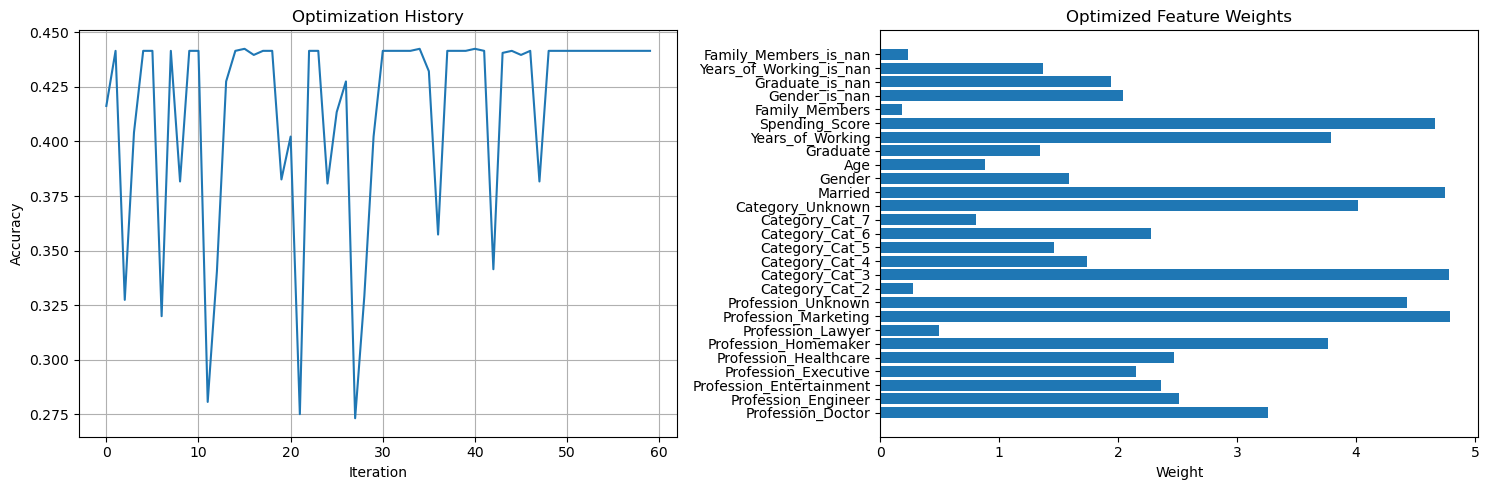


Detailed Optimization Report:

Optimization History:
Iteration 0:
Accuracy: 0.4163
Parameters:
Threshold: 0.400
Profession_Doctor: 4.759
Profession_Engineer: 3.687
Profession_Entertainment: 1.140
Profession_Executive: 0.784
Profession_Healthcare: 1.532
Profession_Homemaker: 1.895
Profession_Lawyer: 2.335
Profession_Marketing: 3.947
Profession_Unknown: 1.078
Category_Cat_2: 2.620
Category_Cat_3: 3.033
Category_Cat_4: 0.864
Category_Cat_5: 0.864
Category_Cat_6: 0.385
Category_Cat_7: 4.344
Category_Unknown: 3.045
Married: 3.570
Gender: 0.201
Age: 4.853
Graduate: 4.179
Years_of_Working: 0.991
Spending_Score: 0.999
Family_Members: 1.591
Gender_is_nan: 2.671
Graduate_is_nan: 2.217
Years_of_Working_is_nan: 1.527
Family_Members_is_nan: 3.098

Iteration 1:
Accuracy: 0.4415
Parameters:
Threshold: 0.574
Profession_Doctor: 0.328
Profession_Engineer: 3.077
Profession_Entertainment: 2.526
Profession_Executive: 1.006
Profession_Healthcare: 4.851
Profession_Homemaker: 3.898
Profession_Lawyer: 4.704
P

ValueError: num must be an integer with 1 <= num <= 8, not 9

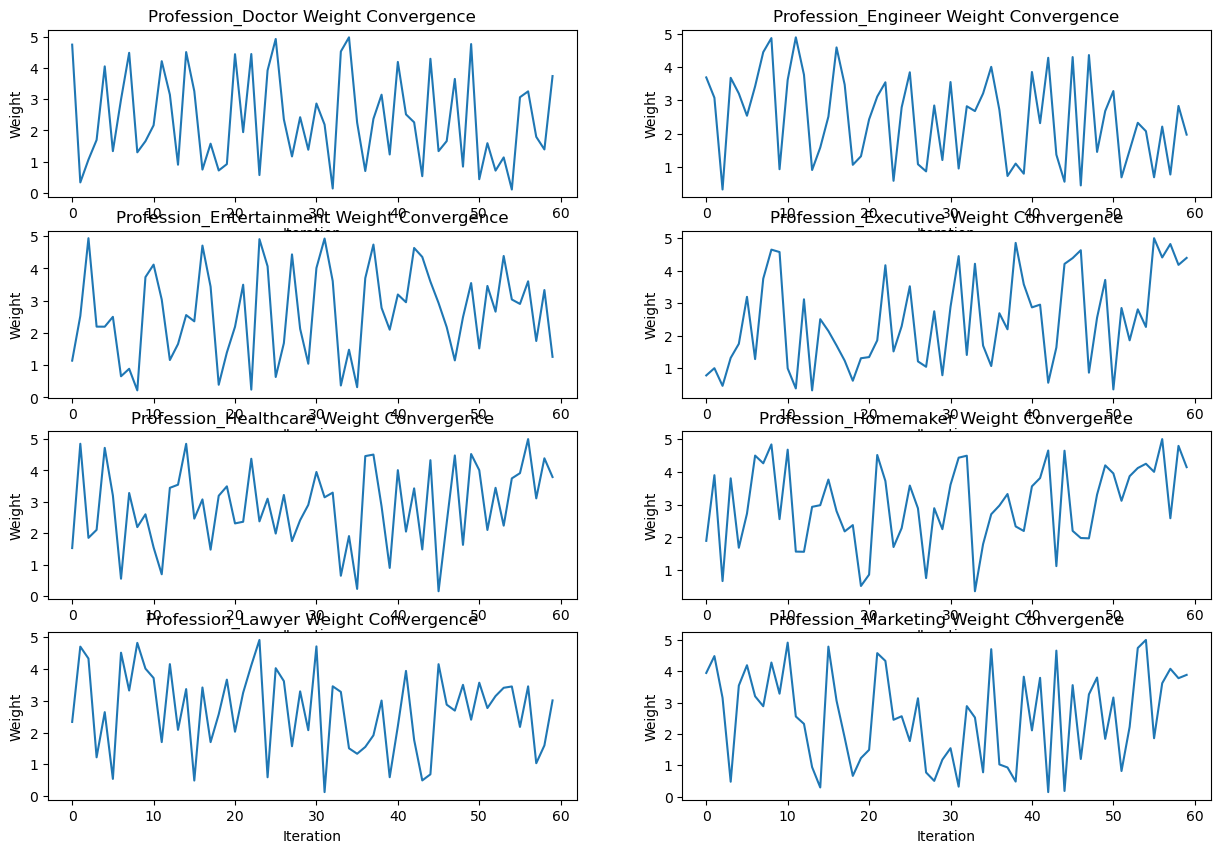

In [168]:
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization
import warnings
warnings.filterwarnings('ignore')

# 数据准备
train_encoded['is_class2'] = (train_encoded['Class(Target)'] == 2).astype(int)
X_train = train_encoded.drop(['is_class2', 'Class(Target)'], axis=1)
y_train_binary = train_encoded['is_class2']

train_others = train_encoded[train_encoded['Class(Target)'] != 2].copy()
label_map = {0: 0, 1: 1, 3: 2}
train_others['Class(Target)'] = train_others['Class(Target)'].map(label_map)
X_train_others = train_others.drop(['Class(Target)', 'is_class2'], axis=1)
y_train_others = train_others['Class(Target)']

X_valid = val_encoded.drop(['Class(Target)'], axis=1)
y_valid = val_encoded['Class(Target)']

# 数据标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_train_others = pd.DataFrame(scaler.transform(X_train_others))

# 定义要优化的特征列表
features_to_optimize = [
    'Profession_Doctor',
    'Profession_Engineer',
    'Profession_Entertainment',
    'Profession_Executive',
    'Profession_Healthcare',
    'Profession_Homemaker',
    'Profession_Lawyer',
    'Profession_Marketing',
    'Profession_Unknown',
    'Category_Cat_2',
    'Category_Cat_3',
    'Category_Cat_4',
    'Category_Cat_5',
    'Category_Cat_6',
    'Category_Cat_7',
    'Category_Unknown',
    'Married',
    'Gender',
    'Age',
    'Graduate',
    'Years_of_Working',
    'Spending_Score',
    'Family_Members',
    'Gender_is_nan',
    'Graduate_is_nan',
    'Years_of_Working_is_nan',
    'Family_Members_is_nan'
]

def create_sample_weights(X, weights_dict):
    sample_weight = np.ones(len(X))
    for feature, weight in weights_dict.items():
        if feature in X.columns:
            sample_weight *= (1 + weight * abs(X[feature]))
    return sample_weight

def evaluate_models(weights_array, threshold):
    # 将权重数组转换为字典
    feature_weights = dict(zip(features_to_optimize, weights_array))
    
    # 训练二分类模型
    sample_weight = create_sample_weights(X_train, feature_weights)
    binary_model = xgb.XGBClassifier(
        learning_rate=0.01,
        max_depth=4,
        min_child_weight=3,
        scale_pos_weight=2,
        n_estimators=200
    )
    binary_model.fit(X_train_scaled, y_train_binary, sample_weight=sample_weight)
    
    # 训练多分类模型
    inverse_feature_weights = {k: 1/v if v != 0 else 1 for k, v in feature_weights.items()}
    multi_sample_weight = create_sample_weights(X_train_others, inverse_feature_weights)
    multi_model = xgb.XGBClassifier(
        learning_rate=0.01,
        max_depth=4,
        min_child_weight=3,
        n_estimators=200
    )
    multi_model.fit(X_train_others, y_train_others, sample_weight=multi_sample_weight)
    
    # 预测
    class2_pred_proba = binary_model.predict_proba(X_valid_scaled)[:, 1]
    is_class2_pred = (class2_pred_proba >= threshold).astype(int)
    other_class_pred = multi_model.predict(X_valid_scaled)
    
    # 合并预测结果
    reverse_label_map = {0: 0, 1: 1, 2: 3}
    final_predictions = []
    for i in range(len(X_valid_scaled)):
        if is_class2_pred[i] == 1:
            final_predictions.append(2)
        else:
            final_predictions.append(reverse_label_map[other_class_pred[i]])
    
    return accuracy_score(y_valid, final_predictions), final_predictions

def objective_function(**kwargs):
    # 提取参数
    weights = [kwargs[f'w{i}'] for i in range(len(features_to_optimize))]
    threshold = kwargs['threshold']
    
    try:
        # 评估模型
        accuracy, _ = evaluate_models(weights, threshold)
        return accuracy
    except:
        return 0.0  # 返回一个较低的值表示该参数组合无效

# 定义参数范围
pbounds = {
    'threshold': (0.1, 0.9)
}
for i in range(len(features_to_optimize)):
    pbounds[f'w{i}'] = (0.1, 5.0)

# 贝叶斯优化
optimizer = BayesianOptimization(
    f=objective_function,
    pbounds=pbounds,
    random_state=42
)

# 运行优化
optimizer.maximize(
    init_points=10,
    n_iter=50
)

# 获取最佳参数
best_params = optimizer.max['params']
best_threshold = best_params['threshold']
best_weights = [best_params[f'w{i}'] for i in range(len(features_to_optimize))]
best_feature_weights = dict(zip(features_to_optimize, best_weights))

# 使用最佳参数评估模型
final_accuracy, final_predictions = evaluate_models(best_weights, best_threshold)

print("\nBest Parameters Found:")
print("\nFeature Weights:")
for feature, weight in best_feature_weights.items():
    print(f"{feature}: {weight:.3f}")
print(f"\nThreshold: {best_threshold:.3f}")

print("\nFinal Model Performance:")
print(f"Accuracy: {final_accuracy:.3f}")
print("\nClassification Report:")
print(classification_report(y_valid, final_predictions))
print("\nConfusion Matrix:")
print(confusion_matrix(y_valid, final_predictions))

# 可视化优化过程
plt.figure(figsize=(15, 5))

# 优化过程图
plt.subplot(1, 2, 1)
optimization_history = [res['target'] for res in optimizer.res]
plt.plot(range(len(optimization_history)), optimization_history)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Optimization History')
plt.grid(True)

# 特征权重可视化
plt.subplot(1, 2, 2)
features = list(best_feature_weights.keys())
weights = list(best_feature_weights.values())
plt.barh(features, weights)
plt.xlabel('Weight')
plt.title('Optimized Feature Weights')

plt.tight_layout()
plt.show()

# 生成详细的优化报告
print("\nDetailed Optimization Report:")
print("\nOptimization History:")
for i, res in enumerate(optimizer.res):
    print(f"Iteration {i}:")
    print(f"Accuracy: {res['target']:.4f}")
    params = res['params']
    print("Parameters:")
    print(f"Threshold: {params['threshold']:.3f}")
    for j in range(len(features_to_optimize)):
        print(f"{features_to_optimize[j]}: {params[f'w{j}']:.3f}")
    print()

# 额外的可视化：参数收敛过程
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features_to_optimize):
    plt.subplot(4, 2, i+1)
    weights_history = [res['params'][f'w{i}'] for res in optimizer.res]
    plt.plot(weights_history)
    plt.title(f'{feature} Weight Convergence')
    plt.xlabel('Iteration')
    plt.ylabel('Weight')
plt.tight_layout()
plt.show()


Evaluating XGBoost...

XGBoost Results:
Validation Accuracy: 0.4696
Cross-validation Score: 0.4705 (+/- 0.0146)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.45      0.54      0.49       241
         1.0       0.54      0.71      0.61       271
         2.0       0.43      0.20      0.28       269
         3.0       0.42      0.43      0.43       288

    accuracy                           0.47      1069
   macro avg       0.46      0.47      0.45      1069
weighted avg       0.46      0.47      0.45      1069


Evaluating LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 171
[LightGBM] [Info] Number of data points in the train set: 7487, number of used features: 27
[LightGBM] [Info] Start training from score -1.480190

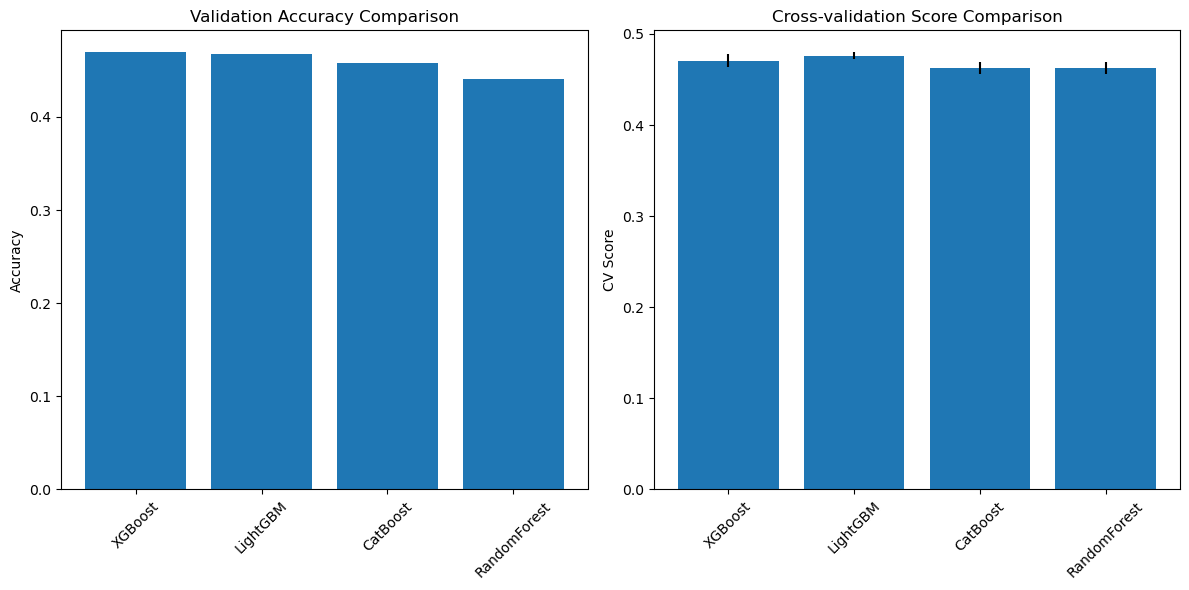


Best performing model: XGBoost
Accuracy: 0.4696


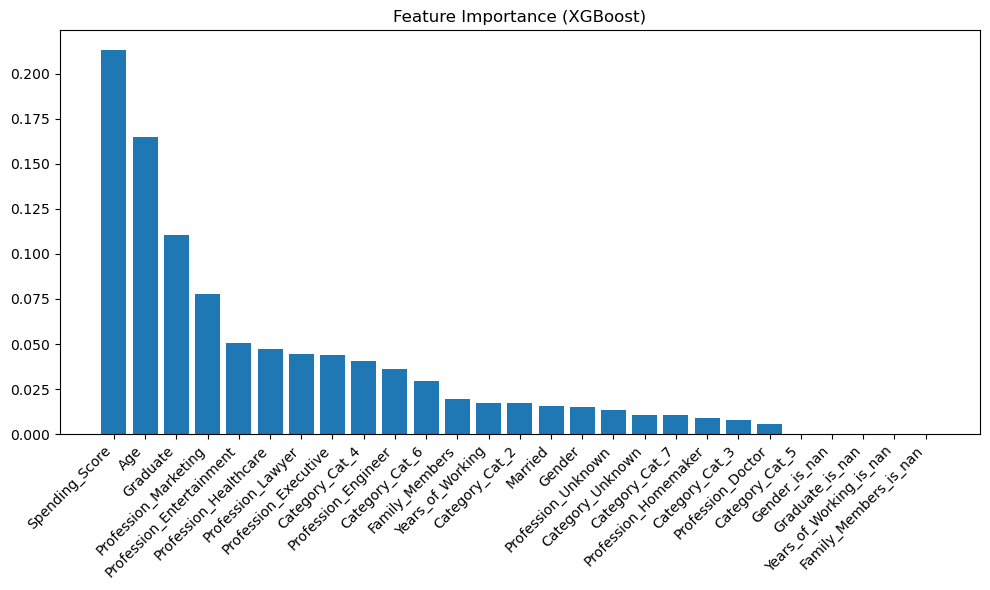